In [1]:
#install pyreadr on terminal
! pip install pyreadr lightgbm

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from termcolor import colored

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.metrics import confusion_matrix,precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier 
from sklearn.ensemble import BaggingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

# Haplotype model - Categorical variable

In [3]:
import pyreadr

# read in female data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_female.rds') # also works for RData
# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
femaleData = result[None] # extract the pandas data frame 

# read in male data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_male.rds') # also works for RData
maleData = result[None] # extract the pandas data frame 

In [4]:
femaleData.head()

,HB1__1067-1,HB1__32843,HB1__64DWA2,HB1__B73,HB1__MANS,HB1__NA,HB1__WDAQ2,HB2__1067-1,HB2__32843,HB2__64DWA2,...,HB17115__7797,HB17115__B73,HB17115__NA,HB17115__RQAA8,HB17116__2FACC,HB17116__7797,HB17116__B73,HB17116__FBMU,HB17116__NA,HB17116__RQAA8
01DHD10,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DHD16,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2-NQR-T1B1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [5]:
maleData.head()

,HB1__01HGI4,HB1__610,HB1__B14,HB1__LH287,HB1__M3AG-3,HB1__NA,HB1__OH43AE1,HB1__PH207,HB2__610,HB2__B14,...,HB17114__OH07,HB17114__PH207,HB17115__LH123,HB17115__NA,HB17115__OH07,HB17115__TA1180,HB17116__LH123,HB17116__NA,HB17116__OH07,HB17116__PH207
LH287,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
83INI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
17IFI6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DILU757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEJO564,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [6]:
# add suffix
femaleData.columns += '_f'
maleData.columns += '_m'

In [7]:
maleData.head()

,HB1__01HGI4_m,HB1__610_m,HB1__B14_m,HB1__LH287_m,HB1__M3AG-3_m,HB1__NA_m,HB1__OH43AE1_m,HB1__PH207_m,HB2__610_m,HB2__B14_m,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
LH287,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
83INI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
17IFI6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DILU757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEJO564,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [8]:
femaleData.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17115__7797_f,HB17115__B73_f,HB17115__NA_f,HB17115__RQAA8_f,HB17116__2FACC_f,HB17116__7797_f,HB17116__B73_f,HB17116__FBMU_f,HB17116__NA_f,HB17116__RQAA8_f
01DHD10,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DHD16,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2-NQR-T1B1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [9]:
allHapFemales = femaleData.index
allHapMales = maleData.index

In [10]:
# read in the train data and test data
trainPheno = pd.read_csv('/mnt/ML_HBLUP/NA_RM105_110_115/data/train_phenoData_NA_Corn_hblup_2015-2020_ALL_UDR_105-110-115.csv')
testPheno = pd.read_csv('/mnt/ML_HBLUP/NA_RM105_110_115/data/test_phenoData_NA_Corn_hblup_2021_ALL_UDR_105-110-115.csv')

In [11]:
trainPheno.head()

,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519


In [12]:
testPheno.head()

,Unnamed: 0,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP
0,1,JYDB2078+JULI2041,JYDB2078,JULI2041,3.853463
1,2,FIDA1520+GALV1529,FIDA1520,GALV1529,0.083630
2,3,HIQO1923+HILU1759,HIQO1923,HILU1759,-9.287542
3,4,FIDA1520-TCJ-T1A2+HILU672-WQQ-T1A1,FIDA1520-TCJ-T1A2,HILU672-WQQ-T1A1,0.519811
4,5,DEDD1628+HILV1970,DEDD1628,HILV1970,-1.873619


In [13]:
# filter trainData by selecting hybrids with both female and male are included in haplotypdata
# and Observation is not NA
trainPheno = trainPheno[(trainPheno['FEMALE'].isin(allHapFemales)) & 
                        trainPheno['MALE'].isin(allHapMales) & 
                        trainPheno['YLD_BE_BLUP'].notna()]

testPheno = testPheno[testPheno['FEMALE'].isin(allHapFemales) & 
                      testPheno['MALE'].isin(allHapMales) & 
                      testPheno['YLD_BE_BLUP'].notna()]

# drop duplicated rows
trainPheno = trainPheno.drop_duplicates()
testPheno = testPheno.drop_duplicates()

In [14]:
print(trainPheno.shape)
print(testPheno.shape)

(33475, 5)
(7307, 5)


In [15]:
# construct haplotype data for test and train data
trainHap = pd.concat([femaleData.loc[trainPheno['FEMALE'],:].reset_index(drop=True),
                      maleData.loc[trainPheno['MALE'],:].reset_index(drop=True)],axis=1)
trainHap = trainHap / 2

testHap = pd.concat([femaleData.loc[testPheno['FEMALE'],:].reset_index(drop=True),
                     maleData.loc[testPheno['MALE'],:].reset_index(drop=True)],axis=1)
testHap = testHap / 2

In [16]:
trainHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# splite the train data into train, validationa and test
seed = 20230510
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(trainHap, trainPheno['YLD_BE_BLUP'], test_size=0.1, random_state=seed)

seed = 20230515
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

## mutate haplotypes from the neural network 

In [17]:
import tensorflow as tf
from tensorflow import keras

2023-06-01 18:22:47.611268: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_12_1:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:
2023-06-01 18:22:47.611323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
# load the saved neural network model
DL_model = tf.keras.models.load_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5')


2023-06-01 18:22:49.004645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-01 18:22:49.004954: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_12_1:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:
2023-06-01 18:22:49.005003: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-01 18:22:49.005034: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-06-01 18:22:49.005271: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enabl

In [ ]:
from scipy.stats import pearsonr

metrics = pd.DataFrame(columns=['Method', 'RMSE_train', 'RMSE_val','RMSE_test','corr_train','corr_val','corr_test'])

pred_train = DL_model.predict(X_train)
pred_val = DL_model.predict(X_val)
pred_test = DL_model.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())


metrics_curr_cv = pd.DataFrame(data={'Method': 'DNN_hapCat', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

### mutate 01DKD2-BGL-T1A1+17IFI6; chr6 

In [19]:
trainPheno.head()

,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519


In [20]:
tmpFemaleHap = femaleData.loc[['01DKD2-BGL-T1A1','FIDA240'],].copy()

In [21]:
tmpFemaleHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17115__7797_f,HB17115__B73_f,HB17115__NA_f,HB17115__RQAA8_f,HB17116__2FACC_f,HB17116__7797_f,HB17116__B73_f,HB17116__FBMU_f,HB17116__NA_f,HB17116__RQAA8_f
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
FIDA240,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [22]:
mmBinNames = tmpFemaleHap.columns[tmpFemaleHap.iloc[0,:].ne(tmpFemaleHap.iloc[1,:])] # mismatched bin names

In [23]:
mmBinNames[0:10]

Index(['HB1__B73_f', 'HB1__NA_f', 'HB2__B73_f', 'HB2__NA_f', 'HB3__B73_f',
       'HB3__NA_f', 'HB4__B73_f', 'HB4__NA_f', 'HB5__B73_f', 'HB5__NA_f'],
      dtype='object')

In [24]:
# single bin replacement
indexRange = range(9843,11146)
mutOut = pd.DataFrame()
for idx in indexRange:
    testBinNames = mmBinNames[mmBinNames.str.startswith('HB' + str(idx))]
    if not testBinNames.empty:
        tmpHap = trainHap.iloc[2:3,:].copy()
        tmpHap[testBinNames] = tmpFemaleHap.loc['FIDA240',testBinNames]
        mutOut = pd.concat([mutOut,tmpHap],axis = 0)

In [25]:
print(mutOut.shape)
mutOut.head()

(203, 109598)


,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
outRes = DL_model.predict(mutOut)

2023-06-01 18:23:05.014854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-01 18:23:05.032965: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


In [27]:
outRes[0:10]

array([[-28.446447],
       [-28.644974],
       [-28.625896],
       [-28.612413],
       [-28.686817],
       [-28.663017],
       [-28.629107],
       [-28.617008],
       [-28.616106],
       [-28.618097]], dtype=float32)

In [47]:
# replace a whold segment for all the lines to FIDA240;
# chr6: 13.2 - 18.1 cM
changedHap = trainHap.copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,32050:32263] = FIDA240Hap.iloc[:,32050:32263] / 2

In [48]:
mutRes = DL_model.predict(changedHap)

2023-06-01 18:42:21.047981: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29350344400 exceeds 10% of free system memory.


In [30]:
mutOut = trainPheno.copy()
mutOut['pred_5cM'] = mutRes
mutOut['pred_DNN'] = DL_model.predict(trainHap)
mutOut['diff_5cM'] = mutOut['pred_5cM'] - mutOut['pred_DNN']
mutOut.head()

2023-06-01 18:25:49.981035: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29350344400 exceeds 10% of free system memory.


,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP,pred_5cM,pred_DNN,diff_5cM
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219,-15.135772,-16.599876,1.464105
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254,-31.022718,-32.975029,1.952311
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251,-21.466608,-28.628584,7.161976
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769,1.900458,-0.239910,2.140368
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519,10.073989,5.629929,4.444060


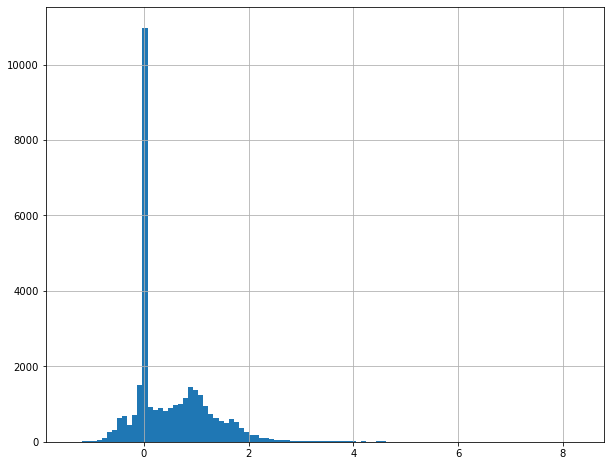

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
mutOut['diff_5cM'].hist(bins = 100, figsize = (10,8))
plt.show()

No handles with labels found to put in legend.


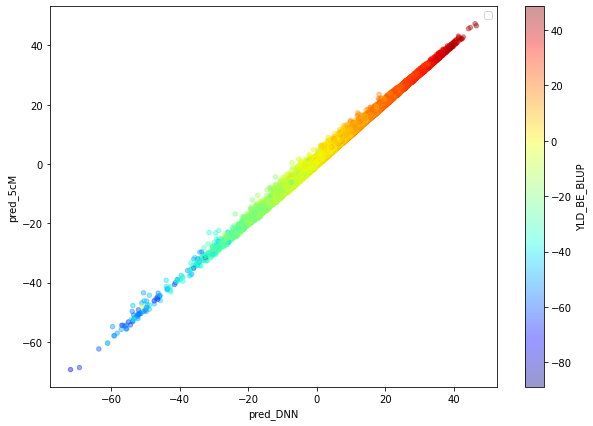

In [51]:
mutOut.plot(kind = 'scatter',x = 'pred_DNN', y = 'pred_5cM', alpha = 0.4,
             figsize = (10,7),
             c = 'YLD_BE_BLUP', cmap = plt.get_cmap('jet'), colorbar = True,
             sharex = False
             )
plt.legend()
plt.show()

No handles with labels found to put in legend.


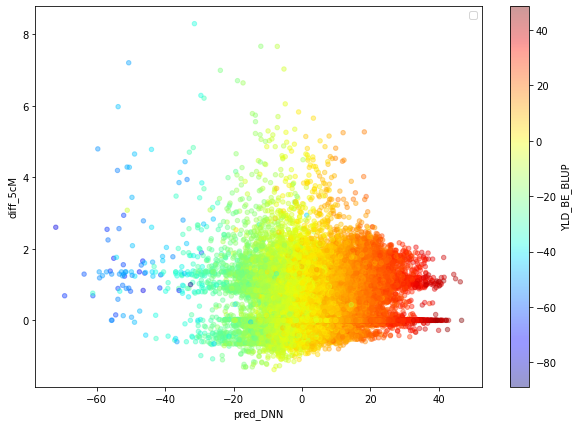

In [52]:
mutOut.plot(kind = 'scatter',x = 'pred_DNN', y = 'diff_5cM', alpha = 0.4,
             figsize = (10,7),
             c = 'YLD_BE_BLUP', cmap = plt.get_cmap('jet'), colorbar = True,
             sharex = False
             )
plt.legend()
plt.show()

No handles with labels found to put in legend.


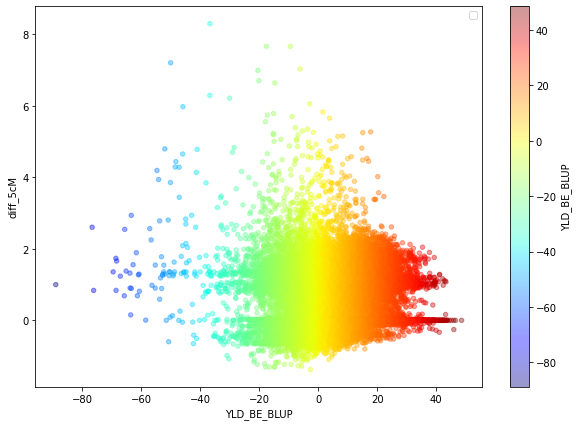

In [53]:
mutOut.plot(kind = 'scatter',x = 'YLD_BE_BLUP', y = 'diff_5cM', alpha = 0.4,
             figsize = (10,7),
             c = 'YLD_BE_BLUP', cmap = plt.get_cmap('jet'), colorbar = True,
             sharex = False
             )
plt.legend()
plt.show()

No handles with labels found to put in legend.


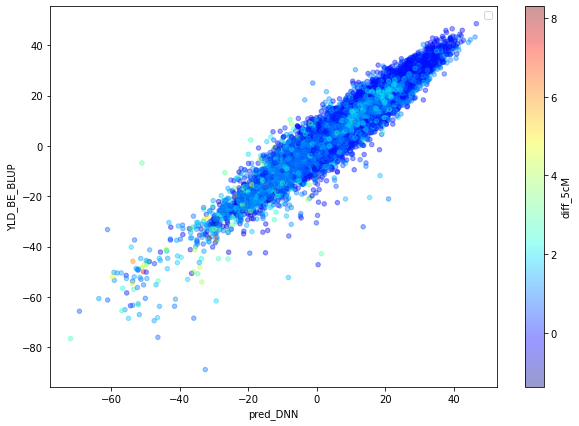

In [54]:
mutOut.plot(kind = 'scatter',x = 'pred_DNN', y = 'YLD_BE_BLUP', alpha = 0.4,
             figsize = (10,7),
             c = 'diff_5cM', cmap = plt.get_cmap('jet'), colorbar = True,
             sharex = False
             )
plt.legend()
plt.show()

In [55]:
# what if replace other regions where 01DKD2 and FIDA240 are different 
# chr6: 22.5-27.4 cM
changedHap = trainHap.copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,32514:32774] = FIDA240Hap.iloc[:,32514:32774] / 2
mutRes = DL_model.predict(changedHap)

2023-06-01 18:46:17.231013: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29350344400 exceeds 10% of free system memory.


In [56]:
mutOut['pred_5cM_seg2'] = mutRes
mutOut['diff_5cM_seg2'] = mutOut['pred_5cM_seg2'] - mutOut['pred_DNN']
mutOut.head()

,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP,pred_5cM,pred_DNN,diff_5cM,pred_5cM_seg2,diff_5cM_seg2
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219,-15.539612,-16.599876,1.060265,-16.084063,0.515814
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254,-31.681723,-32.975029,1.293306,-31.549129,1.425900
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251,-22.412081,-28.628584,6.216503,-27.382595,1.245989
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769,1.378507,-0.239910,1.618417,0.353772,0.593682
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519,9.231547,5.629929,3.601618,6.923815,1.293886


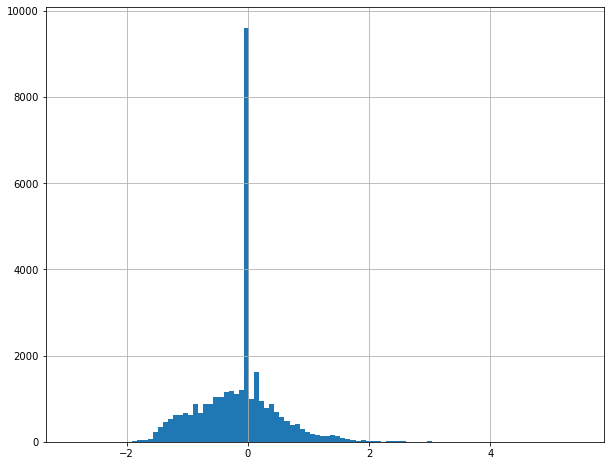

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
mutOut['diff_5cM_seg2'].hist(bins = 100, figsize = (10,8))
plt.show()

No handles with labels found to put in legend.


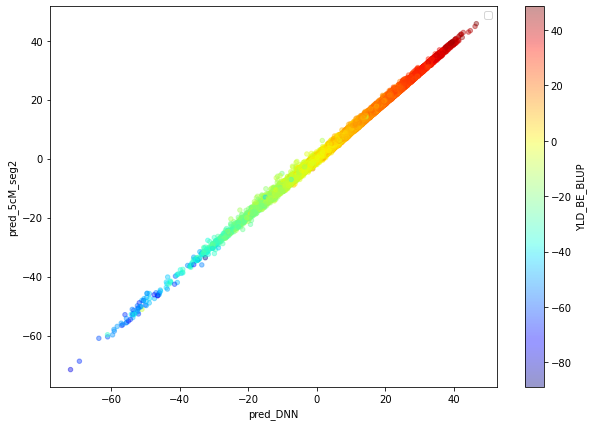

In [58]:
mutOut.plot(kind = 'scatter',x = 'pred_DNN', y = 'pred_5cM_seg2', alpha = 0.4,
             figsize = (10,7),
             c = 'YLD_BE_BLUP', cmap = plt.get_cmap('jet'), colorbar = True,
             sharex = False
             )
plt.legend()
plt.show()

No handles with labels found to put in legend.


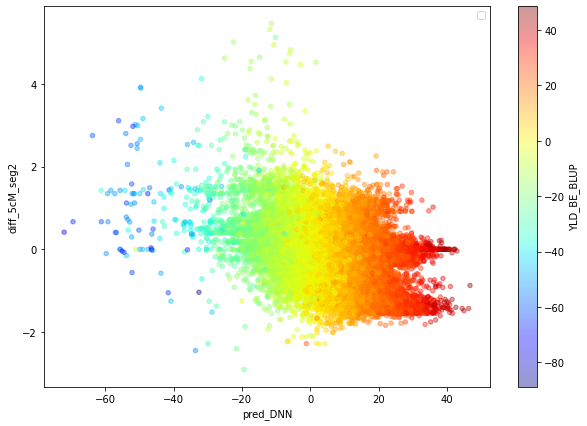

In [59]:
mutOut.plot(kind = 'scatter',x = 'pred_DNN', y = 'diff_5cM_seg2', alpha = 0.4,
             figsize = (10,7),
             c = 'YLD_BE_BLUP', cmap = plt.get_cmap('jet'), colorbar = True,
             sharex = False
             )
plt.legend()
plt.show()

In [61]:
mutOut.to_csv('mutOut.csv')

In [ ]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[2:3,]
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')]
changedHap.iloc[:,31685:32500] = FIDA240Hap.iloc[:,31685:32500]


In [ ]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[2:3,].copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,31685:32600] = FIDA240Hap.iloc[:,31685:32600]
DL_model.predict(changedHap)

### Change 17IFI6 to HINI403 at chr2

In [ ]:
maleData.loc[['17IFI6','HINI403'],].to_csv("/mnt/tmpData/HINI403_17IFI6.csv")

In [ ]:
# testData
mutateHap = pd.read_csv('/mnt/tmpData/mutatedHapToHINI403.csv')

In [ ]:
mutateHap.head()

In [ ]:
rowIndex = mutateHap.iloc[:,0]
rowIndex.head()

In [ ]:
mutateHap = mutateHap.iloc[:,1:]

In [ ]:
mutateHap.head()

In [ ]:
pred_value = DL_model.predict(mutateHap)

In [ ]:
pd.DataFrame(pred_value,index = rowIndex).to_csv("/mnt/tmpData/pred_value_mutate_17IFI6_HINI403.csv")

## JYDA1979+JULW1602

In [ ]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[31482:31483,].copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,32000:32406] = FIDA240Hap.iloc[:,32000:32406]
DL_model.predict(changedHap)

In [ ]:
changedHap.iloc[:,31985:32406]

In [ ]:
DL_model.predict(trainHap.iloc[31482:31483,].copy())

In [ ]:
trainHap.shape

## LightGBM

In [ ]:
# need to install lightgbm from terminal: sudo pip install lightgbm
import lightgbm as lgb

gbm = lgb.LGBMRegressor(num_leaves=20,
                        learning_rate=0.05,
                        n_estimators=900,
                       bagging_fraction =  0.7,
                       feature_fraction = 0.5,
                       objective = "regression")

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mse',
        callbacks=[lgb.early_stopping(5)])

# save model
gbm.booster_.save_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapCat_20_900.txt')

# load model later
    #model = lightgbm.Booster(model_file='file.txt')
    #model.predict(predict[num_columns])
    

In [ ]:
# load the saved model
gbm = lgb.Booster(model_file='/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapCat_20_900.txt')

In [ ]:
from scipy.stats import pearsonr

metrics = pd.DataFrame(columns=['Method', 'RMSE_train', 'RMSE_val','RMSE_test','corr_train','corr_val','corr_test'])
pred_train = gbm.predict(X_train)
pred_val = gbm.predict(X_val)
pred_test = gbm.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())

metrics_curr_cv = pd.DataFrame(data={'Method': 'LightGBM_hapCat', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

## Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.random.set_seed(20230516)

DL_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1]], name = 'input_layer'),
    keras.layers.Dense(100, activation="relu", name = 'hidden_layer1'),
    keras.layers.Dense(300, activation="relu", name = 'hidden_layer2'),
    keras.layers.Dense(1, name = 'output_layer')
])

DL_model.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(0.001)) 

# define the checkpoint
filepath = "/mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
callbacks_list = [checkpoint,early_stopping]

# fit the model
history = DL_model.fit(X_train,y_train,epochs=50,validation_data = (X_val, y_val),callbacks=callbacks_list)


In [ ]:
pred_train = DL_model.predict(X_train)
pred_val = DL_model.predict(X_val)
pred_test = DL_model.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())


metrics_curr_cv = pd.DataFrame(data={'Method': 'DNN_hapCat', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

In [ ]:
DL_model.summary()

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,30)
plt.show()

# try probability model

In [ ]:
# read in female data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/astProb_female.rds') # also works for RData
# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
femaleData = result[None] # extract the pandas data frame 

# read in male data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/astProb_male.rds') # also works for RData
maleData = result[None] # extract the pandas data frame 

In [ ]:
# add suffix
femaleData.columns += '_f'
maleData.columns += '_m'

In [ ]:
# construct haplotype data for test and train data
trainHap = pd.concat([femaleData.loc[trainPheno['FEMALE'],:].reset_index(drop=True),
                      maleData.loc[trainPheno['MALE'],:].reset_index(drop=True)],axis=1)
trainHap = trainHap / 2

testHap = pd.concat([femaleData.loc[testPheno['FEMALE'],:].reset_index(drop=True),
                     maleData.loc[testPheno['MALE'],:].reset_index(drop=True)],axis=1)
testHap = testHap / 2

In [ ]:
print(trainHap.shape)
print(testHap.shape)

In [ ]:
trainHap.head()

In [ ]:
# splite the train data into train, validationa and test
seed = 20230510
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(trainHap, trainPheno['YLD_BE_BLUP'], test_size=0.1, random_state=seed)

seed = 20230515
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
del trainHap; del result; del femaleData; del maleData

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mse',
        callbacks=[lgb.early_stopping(5)])

In [ ]:
pred_train = gbm.predict(X_train)
pred_val = gbm.predict(X_val)
pred_test = gbm.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())

metrics_curr_cv = pd.DataFrame(data={'Method': 'LightGBM_hapProb', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

In [ ]:
# save model
gbm.booster_.save_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapProb_20_900.txt')

# load model later
    #model = lightgbm.Booster(model_file='file.txt')
    #model.predict(predict[num_columns])

In [ ]:
# predict 2021 test blup
pred_2021 = gbm.predict(testHap)
rmse_2021 = mean_squared_error(testPheno['YLD_BE_BLUP'], pred_2021, squared=False)
corr_2021, p_value_2021 = pearsonr(testPheno['YLD_BE_BLUP'].ravel(), pred_2021.ravel())


In [ ]:
print(rmse_2021)
print(corr_2021)